In [70]:
# Cálcula el porcentaje de error entre dos series de máximos anuales.

import itertools
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [83]:
# Cantidad de celdas a eliminar del borde.
k = 1

# Archivos a evaluar.
eval = [ [0, 2], [0, 7], [4, 5], [5, 6] ]
n = 3
i = eval[n][0]
j = eval[n][1]

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_era5_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040", "prec_mroc_hist_hist_days" ]

fname = name[i] + "_" + name[j]
dir = "../results/comp/" + fname + "/"

# Si no existe la carpeta, la crea.
if not os.path.exists(dir):
    os.mkdir(dir)

# valores
path_orig   = "../results/" + name[i] + "/" + name[i] + "_idf_valores.nc" 
path_comp   = "../results/" + name[j] + "/" + name[j] + "_idf_valores.nc" 
# tretorno
#path_orig   = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
#path_comp   = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 
path_orig_s = "../results/" + name[i] + "/" + name[i] + "_stats.nc" 
path_comp_s = "../results/" + name[j] + "/" + name[j] + "_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

# Estadísticas de los valores originales.
ds_orig.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,1.029600e+06
mean,5.821205e+01
std,6.404515e+01
min,3.484559e+00
25%,2.672901e+01
50%,4.212181e+01
75%,6.797705e+01
max,3.376506e+03


In [72]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf(dir + fname + "_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre prec_mroc_hist_hist y prec_mroc_2040_2040
count: 171600.00
mean: 0.03
std: 0.30
min: -0.91
25%: -0.14
50%: 0.03
75%: 0.18
max: 2.36


In [73]:
# Error en el total de precipitación.
prec_e = ( comp_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum()
    / orig_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum() - 1 )

prec_e.describe()

,PRECIPITACION
count,14300.000000
mean,0.022678
std,0.075215
min,-0.262462
25%,-0.021515
50%,0.022833
75%,0.063242
max,0.399005


In [74]:
# Error total.
error = ( ( ds_comp - ds_orig )
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
#error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
#    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ) )
#    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf(dir + fname + ".nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre prec_mroc_hist_hist y prec_mroc_2040_2040
count: 1029600.00
mean: 0.13
std: 0.91
min: -0.89
25%: -0.07
50%: 0.08
75%: 0.23
max: 111.71


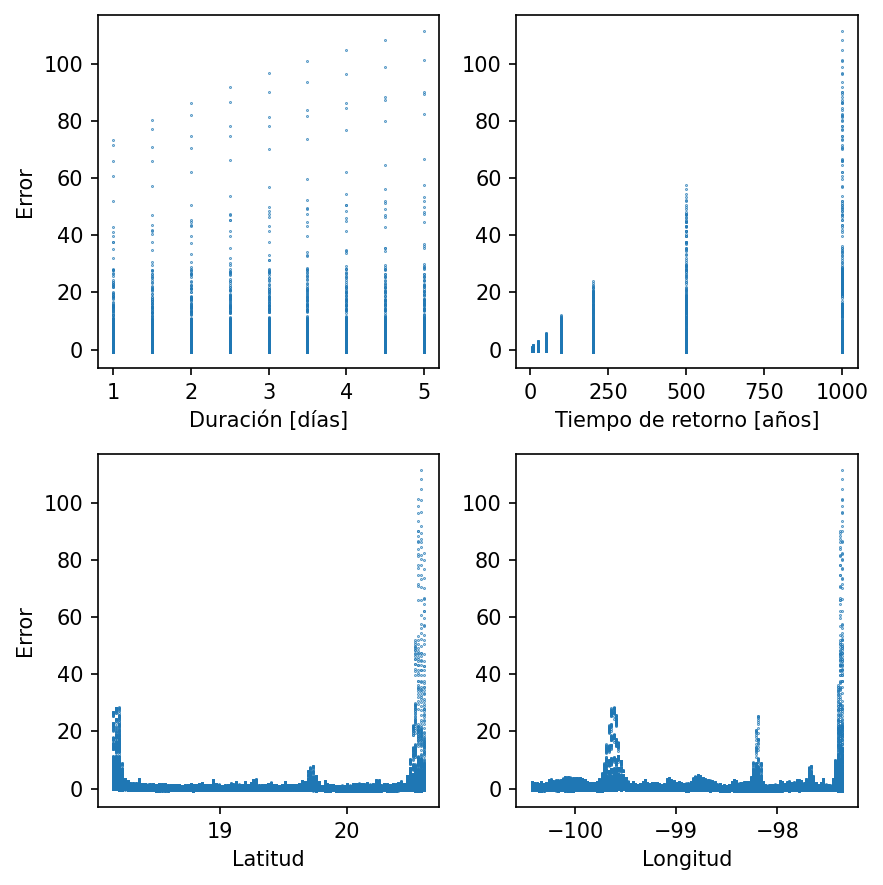

In [75]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

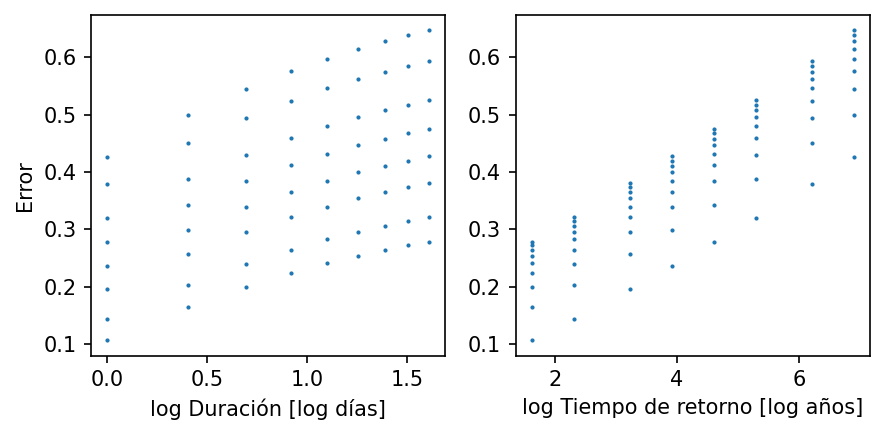

In [76]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 15
N = 15
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
#ax[0].scatter( f_xs.reset_index()["DURACION"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
#ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( np.log( df_xs.reset_index()["TIEMPO_RETORNO"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
#ax[0].set_xlabel(f"Duración [días]")
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
#ax[1].set_xlabel(f"Tiempo de retorno [años]")
ax[1].set_xlabel(f"log Tiempo de retorno [log años]")

fig.tight_layout()
plt.show()

In [77]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log(  df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.log(  df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              "T_1",
                              #"T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     5475.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           9.72e-77
Time:                        19:18:41   Log-Likelihood:                 227.05
No. Observations:                  72   AIC:                            -448.1
Df Residuals:                      69   BIC:                            -441.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0088      0.004     -2.149      0.035      -0.017      -0.001
D_1            0.1199      0.002     48.746      0.000       0.115       0.125
T_1            0.0664      0.001     92.591      0.000       0.065       0.068
==============================================================================
Omnibus:                        3.354   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.305
Skew:                          -0.493   Prob(JB):                        0.192
Kurtosis:                       2.641   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# Intentamos obtener un valor para todo el dominio.

# Error normalizado
#error_n = ( error / error.sel(DURACION = 1, TIEMPO_RETORNO = 5 )
#    ).to_dataframe().droplevel(level = (0, 1) ).reset_index()
# Error sin normalizar.
error_n = df_e.copy().reset_index()

# Regresión múltiple logarítmica.
X = sm.add_constant( np.log( error_n[["DURACION", "TIEMPO_RETORNO"]] ) )
Y = error_n[["P_ERROR"]]
model = sm.OLS(Y,X)
results = model.fit()
# Ajuste de la regresión.
results.rsquared_adj

0.002892372179299274

In [79]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR",
        "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR",
        #"C_TRET",
        "P_CONST",
        "P_LOG_DUR",
        "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #"P_DUR",
        #"P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            #"DURACION",
            #"TIEMPO_RETORNO",
            "LOG_DURACION",
            "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

for c in df_s.columns:
    df_s[c] = df_s[c].astype(float)

# Guardamos el archivo.
df_s.to_xarray().to_netcdf(dir + fname + "_reglin.nc")

# Estadísticas de los valores de la regresión.
df_s.describe()

KeyboardInterrupt: 

In [ ]:
# Calcula la intensidad de precipitación corregida.

# Generamos las variables de manera matricial.
T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    (132 - k * 2, 112 - k * 2, 9, 8) )[:, :, :, 0:8]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    (132 - k * 2, 112 - k * 2, 8, 9) )[:, :, :, 0:9], 3, 2 ) 
B0 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["CONST"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 9, 8) )

#T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
#    (132 - k * 2, 112 - k * 2, 12, 31) )[:, :, :, 0:31]
#D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
#    (132 - k * 2, 112 - k * 2, 31, 12) )[:, :, :, 0:12], 3, 2 ) 
#B0 = np.tile( np.expand_dims( np.swapaxes(
#    df_s.to_xarray()["CONST"].to_numpy(), 0, 1),
#    (2, 3) ), (1, 1, 12, 31) )

B1 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_LOG_DUR"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 9, 8) )
B2 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_LOG_TRET"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 9, 8) )


#B1 = np.tile( np.expand_dims( np.swapaxes(
#    df_s.to_xarray()["C_LOG_DUR"].to_numpy(), 0, 1),
#    (2, 3) ), (1, 1, 12, 31) )
#B2 = np.tile( np.expand_dims( np.swapaxes(
#    df_s.to_xarray()["C_LOG_TRET"].to_numpy(), 0, 1),
#    (2, 3) ), (1, 1, 12, 31) )

# Predicción.
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_orig.copy()
#ds_corr = ds_comp.drop( ["AÑO"] ).copy()
#ds_corr["INTENSIDAD"] = ( list( ds_orig.dims ),
#    np.swapaxes( ds_corr["INTENSIDAD"].to_numpy(), 0, 1) / ( REG + 1 ) )
ds_corr["P_ERROR"] = ( list( ds_corr.dims ), np.swapaxes( REG, 0, 1 ) ) 
ds_corr["INTENSIDAD"] = ds_corr["INTENSIDAD"] * ( ds_corr["P_ERROR"] +  1 )
#ds_corr["INTENSIDAD"] = ( list( ds_orig.dims ),
#    ds_corr["INTENSIDAD"].to_numpy() / ( np.swapaxes( REG + 1, 0, 1 ) ) )

# Guardamos.
ds_corr.to_netcdf(dir + fname + "_corr.nc")

# Estadísticas de los valores de la regresión.
ds_corr.to_dataframe()[["INTENSIDAD"]].describe()

,LATITUD,LONGITUD,DURACION,TIEMPO_RETORNO,INTENSIDAD,P_ERROR
count,1.029600e+06,1.029600e+06,1.029600e+06,1.029600e+06,1.029600e+06,1.029600e+06
mean,1.938528e+01,-9.889336e+01,3.000000e+00,2.362500e+02,1.174061e+02,8.119092e-01
std,7.133981e-01,8.938317e-01,1.290995e+00,3.272496e+02,1.128080e+02,1.173728e+00
min,1.815781e+01,-1.004297e+02,1.000000e+00,5.000000e+00,-7.977120e+02,-4.103773e+01
25%,1.876781e+01,-9.966747e+01,2.000000e+00,2.125000e+01,5.822309e+01,3.421370e-01
50%,1.938684e+01,-9.889336e+01,3.000000e+00,7.500000e+01,8.922445e+01,7.662254e-01
75%,2.000353e+01,-9.811926e+01,4.000000e+00,2.750000e+02,1.399831e+02,1.140893e+00
max,2.060667e+01,-9.735706e+01,5.000000e+00,1.000000e+03,9.996388e+03,1.103708e+02


In [ ]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Float64Index([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64', name='DURACION')


INTENSIDAD   P_ERROR
LATITUD   LONGITUD                         
18.157814 -100.429665  -35.286454 -2.196581
          -100.405846  -31.132449 -2.048763
          -100.382027  -27.627426 -1.937544
          -100.358208  -26.226470 -1.920684
          -100.334389  -22.464490 -1.809243
...                           ...       ...
20.606667 -99.214912    -1.848103 -1.131009
          -99.191093    -1.542495 -1.109286
          -99.167274    -2.196131 -1.151254
          -99.143456    -2.367934 -1.161548
          -99.119637    -0.618420 -1.043804

[323 rows x 2 columns]

In [ ]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf(dir + fname + "_espacial.nc")